<a href="https://colab.research.google.com/github/wjziv/pudding/blob/master/Cook_Co_Incarceration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialize + Access

Get access to the Cook County data given by website.

In [1]:
!pip install pandas
!pip install sodapy
!pip install numpy

import time
import datetime as dt
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

# Authenticated client (needed for non-public datasets):
client_link = 'datacatalog.cookcountyil.gov'
wjztoken    = 'aFpl9dxptMD8U7HBwwezf0VTj'
wjzuser     = 'walterzielenski@gmail.com'
wjzpass     = '6a3Mu*dSTB5d$i0AX%'
client      = Socrata(client_link, 
                      wjztoken, 
                      username = wjzuser, 
                      password = wjzpass)

    100% |████████████████████████████████| 92kB 3.3MB/s 
spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.19.1 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


#The Full Data

The Intake data is comprised of cases (rows).  Not all are provided to the FRU. Cases which are not presented to them are filtered out (where fr_result is NULL).

The remainder may be Approved--if so, FRU is finished, and case is opened to litigation. If not Approved, it is considered one of many options. See first item in 'Data Check'.

**This analysis forgoes any cases filed directly by Chicago PD, or those which went directly into trial. Only those first handled by FRU are considered for analysis. Further, only months with over 500 entries are considered.**

*As a note, [this](https://ecommons.luc.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1001&context=criminaljustice_facpubs) is an interesting paper discussing mandatory sentencing in Illinois, and it explains the arch in the data below, if it isn't due to police getting used to new technology.*

In [2]:

ids =     {'initiation':'7mck-ehwz',   
           'disposition':'xx5u-5k6q',  
           'sentencing':'5jef-8d3b',   
           'intake':'pmqy-gxnr'}       

arch_ids = {'initiation':'qr2q-atnt',    
            'disposition':'75tm-jf99', 
            'sentencing':'qhfs-h477',    
            'intake':'a2mv-5et6'}       

query_id    = ids['intake']
entry_limit = 400000

select_soql = 'case_participant_id,offense_category,race,law_enforcement_agency,fr_date,fr_result'
group_soql  = ''
where_soql  = 'fr_result is not null'
order_soql  = ''
results_before = client.get(query_id, 
                            select = select_soql, 
                            #group = group_soql,
                            where  = where_soql, 
                            #order = order_soql,
                            limit  = entry_limit)

df = pd.DataFrame.from_records(results_before)
df_backup = df
df.head()

,case_participant_id,fr_date,fr_result,law_enforcement_agency,offense_category,race
0,1248849694831,2017-05-23T00:00:00.000,Approved,STONE PARK PD,Burglary,White
1,1202260405467,2015-09-11T00:00:00.000,Approved,CHICAGO PD,Armed Robbery,Black
2,1276527891299,2018-05-30T00:00:00.000,Approved,ISP DISTRICT CHICAGO,Aggravated DUI,Black
3,1270320607948,2018-03-09T00:00:00.000,Approved,CHICAGO PD,UUW - Unlawful Use of Weapon,Black
4,1248588660533,2017-05-18T00:00:00.000,Approved,CHICAGO PD,Aggravated Fleeing and Eluding,White


##Data Backup and Extra Functions

In [3]:
df = df_backup

# Turn date into a convenient format.

df['year_month'] = df['fr_date'].astype(str).str[:7]

## Convenient functions.

def mask(df, key, value):
  return df[df[key] == value]
pd.DataFrame.mask = mask

print('Done.')

Done.


##Data Check and Filter

In [4]:
df.groupby(['fr_result']).size()

fr_result
Advice                        173
Approved                   137931
Continued Investigation      6014
Deputy Override                19
Disregard                     179
Rejected                    15409
VICTIM SENSITIVE INT           13
Warr Ord Warr Issued           27
Warrant Exec                    8
dtype: int64

In [5]:
# How many cases per month?

df.groupby(['year_month']).size().head()

year_month
1976-08    1
2001-12    1
2004-07    1
2007-03    1
2007-06    1
dtype: int64

In [6]:
# Remove Outlying Months. Only consider months where >500 cases.
# This also settles typo errors on data entry for months/years that have not yet occurred.

# Also create df_approved, consisting only of approved cases.

df['total_cases'] = df.groupby('year_month')['year_month'].transform('count')
df = df[df['total_cases'] > 500].sort_values('year_month').reset_index()
df_totals = df.groupby(['year_month']).size().rename('total_cases').reset_index()

df_approved = df.mask('fr_result', 'Approved')
df_approved.head()

,index,case_participant_id,fr_date,fr_result,law_enforcement_agency,offense_category,race,year_month,total_cases
0,85130,1058040779852,2011-01-13T00:00:00.000,Approved,CHICAGO PD,Armed Robbery,Black,2011-01,1779
1,12202,1058676945699,2011-01-22T00:00:00.000,Approved,BLUE ISLAND PD,Driving With Suspended Or Revoked License,Black,2011-01,1779
2,73071,1058717504254,2011-01-24T00:00:00.000,Approved,CHICAGO PD,UUW - Unlawful Use of Weapon,White [Hispanic or Latino],2011-01,1779
3,132086,1057047446107,2011-01-03T00:00:00.000,Approved,CHICAGO PD,Possession of Stolen Motor Vehicle,Black,2011-01,1779
4,67540,1057905912131,2011-01-12T00:00:00.000,Approved,ROBBINS PD,UUW - Unlawful Use of Weapon,White,2011-01,1779


#Primary Organization

* Approval (by date)
* Race
* Offense
* Repeat Offender
* City / Suburb


##General Approval Rate
`df_totals`

In [9]:
## Approval / Rejection by Time

df_approved_grouped = df_approved.groupby(['year_month']).size().rename('total_approved').reset_index()
df_totals['total_approved'] = df_approved_grouped['total_approved']
df_totals['%_approved'] = df_totals['total_approved'] / df_totals['total_cases']
df_totals.head()


,year_month,total_cases,total_approved,%_approved
0,2011-01,1779,1501,0.843732
1,2011-02,1377,1191,0.864924
2,2011-03,1689,1456,0.862049
3,2011-04,1882,1590,0.844846
4,2011-05,1879,1600,0.851517


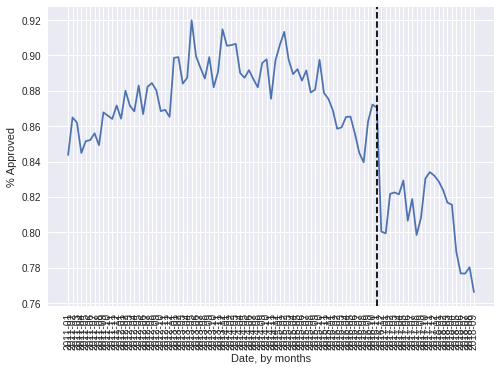

In [10]:
## Approval / Rejection
# Plotting.

plt.plot(df_totals['year_month'], df_totals['%_approved'])
plt.axvline(x='2016-11', color='k', linestyle='--')
plt.ylabel('% Approved')
plt.xlabel('Date, by months')
plt.xticks(rotation=90)
plt.show()

## The black line marks the taking of office by Kim Foxx.

##Race
`df_totals_race`

In [11]:
## Race
# See races of all charges, not just approved. Using df, not df_approved.
print(df['race'].unique())

['Black' 'White [Hispanic or Latino]' 'White' nan 'HISPANIC' 'Asian'
 'White/Black [Hispanic or Latino]' 'Biracial' 'Unknown' 'American Indian'
 'Albino' 'ASIAN' 'CAUCASIAN']


In [13]:
## Race
# See races of all charges, not just approved. Using df, not df_approved.
# Is it worthwhile to filter offenses to items above a threshold? Yes.
race_threshhold = 999
df_race_counts = df.groupby(['race']).size().rename('total_each').reset_index()
df_race_counts_filtered = df_race_counts[df_race_counts['total_each'] > race_threshhold].sort_values('total_each',ascending=False)
df_race_counts_filtered

,race,total_each
5,Black,97815
10,White [Hispanic or Latino],25320
9,White,23964
7,HISPANIC,5955
3,Asian,1139


In [14]:
## Race
# Moving forward, filtered race data.

df_totals_race = df_totals.copy()

for race in df_race_counts_filtered['race']:
  
  df_race     = df.mask('race',race).groupby(['year_month']).size().rename('total_{}'.format(race)).reset_index()
  df_app_race = df_approved.mask('race',race).groupby(['year_month']).size().rename('app_{}'.format(race)).reset_index()
  df_totals_race['total_{}'.format(race)]  = df_race['total_{}'.format(race)]
  df_totals_race['app_{}'.format(race)]    = df_app_race['app_{}'.format(race)]
  df_totals_race['%_app_{}'.format(race)]  = df_app_race['app_{}'.format(race)] / df_race['total_{}'.format(race)]

df_totals_race.head()

,year_month,total_cases,total_approved,%_approved,total_Black,app_Black,%_app_Black,total_White [Hispanic or Latino],app_White [Hispanic or Latino],%_app_White [Hispanic or Latino],total_White,app_White,%_app_White,total_HISPANIC,app_HISPANIC,%_app_HISPANIC,total_Asian,app_Asian,%_app_Asian
0,2011-01,1779,1501,0.843732,1077,908,0.843083,272,249,0.915441,271,229,0.845018,94,74,0.787234,11,7,0.636364
1,2011-02,1377,1191,0.864924,756,658,0.870370,211,195,0.924171,257,220,0.856031,86,72,0.837209,9,6,0.666667
2,2011-03,1689,1456,0.862049,970,825,0.850515,286,272,0.951049,296,260,0.878378,86,66,0.767442,11,10,0.909091
3,2011-04,1882,1590,0.844846,1095,920,0.840183,308,287,0.931818,316,272,0.860759,85,59,0.694118,10,9,0.900000
4,2011-05,1879,1600,0.851517,1102,938,0.851180,322,304,0.944099,310,270,0.870968,88,55,0.625000,12,10,0.833333


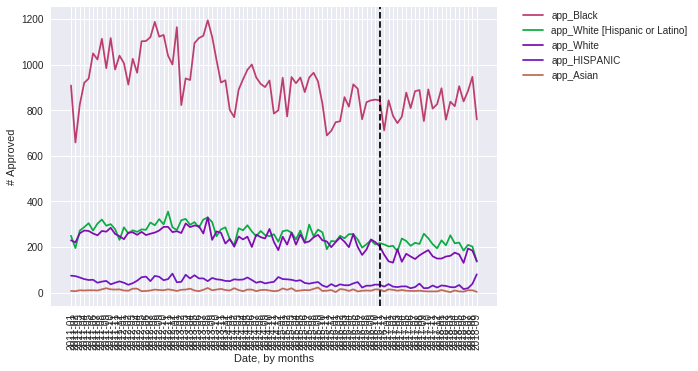

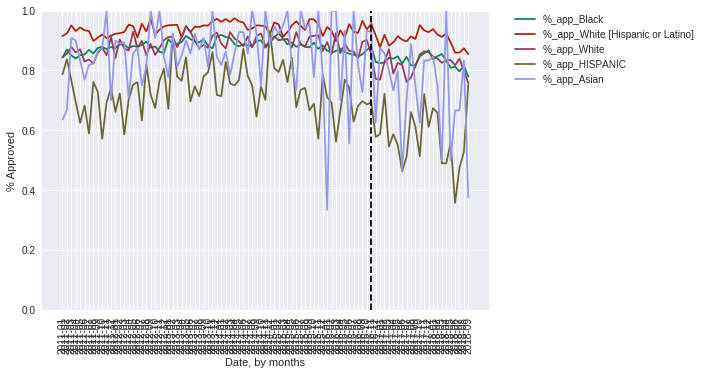

In [107]:
## Race
# Plotting.

for race in df_race_counts_filtered['race']:
  plt.plot(df_totals_race['year_month'], df_totals_race['app_{}'.format(race)], c = np.random.rand(3))

plt.axvline(x='2016-11', color='k', linestyle='--')
plt.ylabel('# Approved')
plt.xlabel('Date, by months')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

for race in df_race_counts_filtered['race']:
  plt.plot(df_totals_race['year_month'], df_totals_race['%_app_{}'.format(race)], c = np.random.rand(3))

plt.axvline(x='2016-11', color='k', linestyle='--')
plt.ylabel('% Approved')
plt.xlabel('Date, by months')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,1])
plt.show()

##Offense
`df_totals_offense`

In [91]:
## Offense

print(df['offense_category'].unique())

['Armed Robbery' 'Driving With Suspended Or Revoked License'
 'UUW - Unlawful Use of Weapon' 'Possession of Stolen Motor Vehicle'
 'Robbery' 'Residential Burglary' 'Criminal Damage to Property' 'Burglary'
 'Retail Theft' 'Arson' 'Aggravated DUI' 'Other Offense'
 'Obstructing Justice' 'DUI' 'Aggravated Battery Police Officer' 'Theft'
 'Forgery' 'Attempt Armed Robbery' 'Aggravated Discharge Firearm'
 'Credit Card Cases' 'Sex Crimes' 'Narcotics' 'Domestic Battery'
 'Escape - Failure to Return' 'Failure to Register as a Sex Offender'
 'Aggravated Battery With A Firearm' 'Aggravated Battery'
 'Aggravated Fleeing and Eluding' 'Prostitution' 'Home Invasion'
 'Fraudulent ID' 'Bribery' 'Criminal Trespass To Residence' 'Bomb Threat'
 'Official Misconduct' 'Theft by Deception' 'Homicide'
 'Disarming Police Officer' 'Impersonating Police Officer'
 'Identity Theft' 'Reckless Discharge of Firearm'
 'Violation Order Of Protection' 'Attempt Sex Crimes' 'Aggravated Robbery'
 'Deceptive Practice' 'Attem

In [97]:
## Offense
# Seeing all offenses, not just those off df_approved.
# Is it worthwhile to filter offenses to items above a threshold? Yes.
offender_threshhold   = 1999
df_offense_categories = df.groupby(['offense_category']).size().rename('total_offenders').reset_index()
df_offense_categories_filtered = df_offense_categories[df_offense_categories['total_offenders'] > offender_threshhold].sort_values('total_offenders',ascending=False)
df_offense_categories_filtered.head()

,offense_category,total_offenders
79,UUW - Unlawful Use of Weapon,22860
72,Retail Theft,21423
6,Aggravated DUI,11084
24,Burglary,10438
36,Driving With Suspended Or Revoked License,9475
77,Theft,6340
74,Sex Crimes,5930
12,Armed Robbery,5355
67,Possession of Stolen Motor Vehicle,4808
71,Residential Burglary,4741


In [98]:
## Offense
# Moving forward, filtered offense data.

df_totals_offense = df_totals.copy()

for offense in df_offense_categories_filtered['offense_category']:
  
  df_offense     = df.mask('offense_category',offense).groupby(['year_month']).size().rename('total_{}'.format(offense)).reset_index()
  df_app_offense = df_approved.mask('offense_category',offense).groupby(['year_month']).size().rename('app_{}'.format(offense)).reset_index()
  df_totals_offense['total_{}'.format(offense)]  = df_offense['total_{}'.format(offense)]
  df_totals_offense['app_{}'.format(offense)]    = df_app_offense['app_{}'.format(offense)]
  df_totals_offense['%_app_{}'.format(offense)]  = df_app_offense['app_{}'.format(offense)] / df_offense['total_{}'.format(offense)]

df_totals_offense.head()

,year_month,total_cases,total_UUW - Unlawful Use of Weapon,app_UUW - Unlawful Use of Weapon,%_app_UUW - Unlawful Use of Weapon,total_Retail Theft,app_Retail Theft,%_app_Retail Theft,total_Aggravated DUI,app_Aggravated DUI,...,%_app_Failure to Register as a Sex Offender,total_Homicide,app_Homicide,%_app_Homicide,total_Domestic Battery,app_Domestic Battery,%_app_Domestic Battery,total_Criminal Damage to Property,app_Criminal Damage to Property,%_app_Criminal Damage to Property
0,2011-01,1779,211,191,0.905213,201,144,0.716418,152,138,...,0.850000,24,21,0.875000,13,10,0.769231,30,26,0.866667
1,2011-02,1377,152,147,0.967105,164,126,0.768293,126,115,...,0.827586,15,10,0.666667,24,13,0.541667,16,14,0.875000
2,2011-03,1689,206,194,0.941748,181,140,0.773481,133,125,...,0.848485,22,12,0.545455,19,13,0.684211,19,14,0.736842
3,2011-04,1882,222,205,0.923423,226,181,0.800885,168,139,...,0.884615,32,20,0.625000,15,9,0.600000,26,21,0.807692
4,2011-05,1879,240,229,0.954167,269,188,0.698885,162,148,...,0.843750,22,12,0.545455,8,7,0.875000,35,32,0.914286


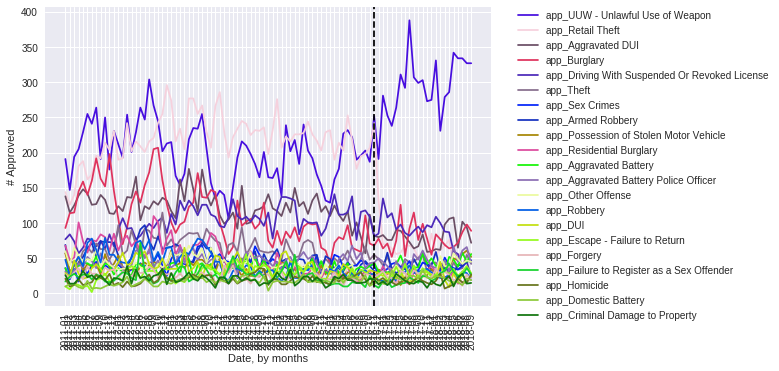

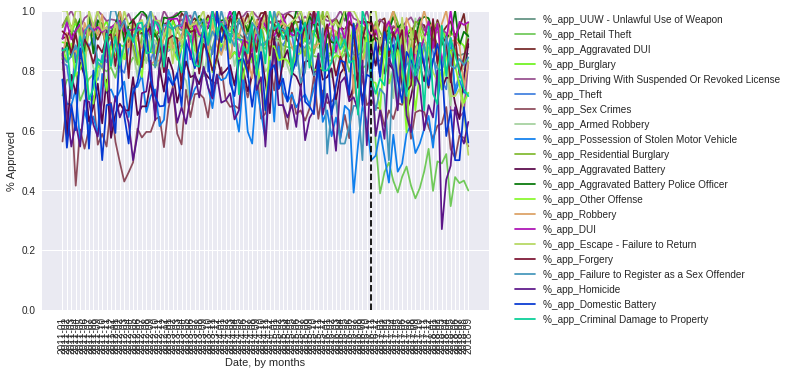

In [99]:
## Offense
# Plotting.

for offense in df_offense_categories_filtered['offense_category']:
  plt.plot(df_totals_offense['year_month'], df_totals_offense['app_{}'.format(offense)], c = np.random.rand(3))

plt.axvline(x='2016-11', color='k', linestyle='--')
plt.ylabel('# Approved')
plt.xlabel('Date, by months')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

for offense in df_offense_categories_filtered['offense_category']:
  plt.plot(df_totals_offense['year_month'], df_totals_offense['%_app_{}'.format(offense)], c = np.random.rand(3))

plt.axvline(x='2016-11', color='k', linestyle='--')
plt.ylabel('% Approved')
plt.xlabel('Date, by months')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,1])
plt.show()

##Repeat Offense

What is the best way to find disctinction here?

In [108]:
## Repeat offense

## ...No repeat offenders?

select_soql_rep = 'count(case_participant_id),case_participant_id'
group_soql_rep  = 'case_participant_id'
where_soql_rep  = 'fr_result is not null'
order_soql_rep  = 'count(case_participant_id) DESC'
results_rep     = client.get(query_id, 
                             select = select_soql_rep, 
                             group  = group_soql_rep,
                             #where  = where_soql_rep, 
                             order  = order_soql_rep,
                             limit  = entry_limit)

df_rep = pd.DataFrame.from_records(results_rep)

df_rep.head()

,case_participant_id,count_case_participant_id
0,1238043857251,1
1,1102706274503,1
2,1244001473926,1
3,1242597362013,1
4,1090872158263,1


##Mandatory Min + Long Max Sentence

Find data on the classification of each type. Consider alternative grouping.

In [0]:
## Mandatory Min / Long Max

http://www.ilga.gov/
http://www.ilga.gov/commission/lru/2014PFC.pdf
https://www.cga.ct.gov/2008/rpt/2008-R-0619.htm
https://restorejustice.org/know-more-felony-class-mandatory-minimums/
https://andrewnickel.com/felony-illinois/
https://www.puryearlaw.com/2015/11/27/illinois-felony-sentences/

##City vs Suburb

The distinction used in the Cook County official report is which `law_enforcement_agency` entered the charge into the database.

`City if law_enforcement_agency == 'Chicago PD'`

Note that most city cases forgo the FRU approval process, as they are typically drug charges. Any case that has not gone through FRU is not considered here.

In [0]:
## City / Suburb
## city if [law_enforcement_agency] = CHICAGO PD